In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import piecewise_linear, chisquared
from utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [4]:
raw = np.genfromtxt("../mocksamples/simpleburst.dat")
data = vice.dataframe({})
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]
data["logage"] = raw[:, 4]
data["logage_err"] = raw[:, 5]
# data["age"] = np.array([10**_ for _ in raw[:, 4]])
# data["age_err"] = np.array([a * b * m.log(10) for a, b in zip(data["age"], raw[:, 5])])

rawchain = np.genfromtxt("../mocksamples/simpleburst_rampupduration_5000.out")
print(len(rawchain))
chain = vice.dataframe({})
chain["tau_in"] = rawchain[:, 0]
chain["eta"] = rawchain[:, 1]
chain["tau_tot"] = rawchain[:, 2]
chain["delta_1"] = rawchain[:, 3]
# chain["tau_star_1"] = rawchain[:, 4]
chain["logp"] = rawchain[:, 4]

5000


<ipython-input-3-e49c6f66b958>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


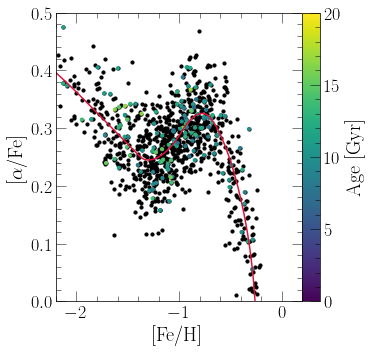

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-2.2, 0.2])
ax.set_ylim([0, 0.5])

kwargs = {
    "s": 10,
    "c": named_colors()["black"]
}
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
kwargs["s"] = 10
kwargs["c"] = [10**_ for _ in data["logage"]]
kwargs["vmin"] = 0
kwargs["vmax"] = 20
kwargs["cmap"] = "viridis"
sc = ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
cbar_ax = fig.add_axes([0.1, 0.1, 0.1, 0.1])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 5)
cbar.set_ticks(range(0, 25, 5))

out = vice.output("../mock")
ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.subplots_adjust(right = 0.85)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
plt.show()

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\


199


<ipython-input-7-b9931049c5a4>:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


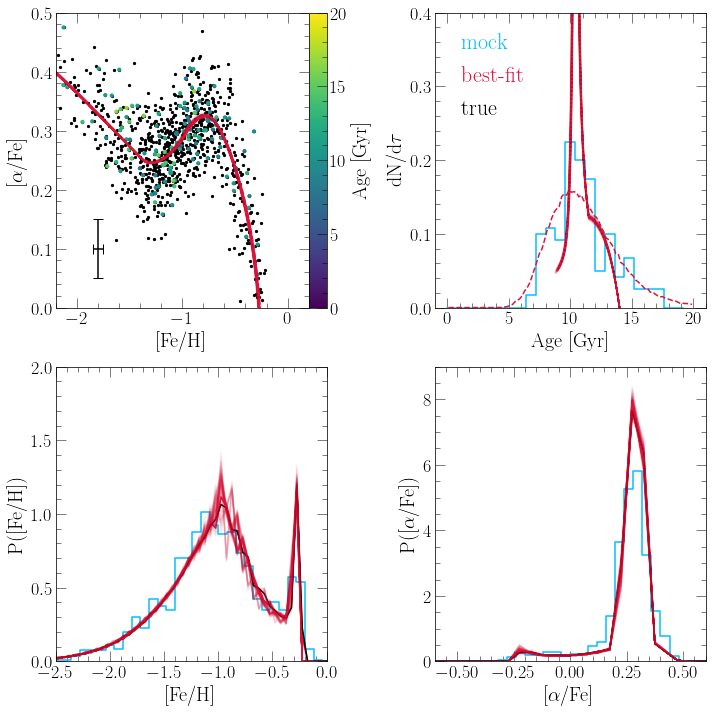

In [7]:
fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)
        
axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel(r"[$\alpha$/Fe]")
axes[0][0].set_xlim([-2.2, 0.2])
axes[0][0].set_ylim([0., 0.5])

feh_err = np.median(data["[fe/h]_err"])
ofe_err = np.median(data["[o/fe]_err"])
axes[0][0].errorbar(-1.8, 0.1, xerr = feh_err, yerr = ofe_err,
    c = named_colors()["black"], linestyle = "None")

duration = 5.03
with vice.singlezone(name = "bestfit") as sz:
    sz.func = exponential(timescale = 2.00)
    sz.mode = "ifr"
    sz.elements = ["fe", "o"]
    sz.Mg0 = 0
    sz.nthreads = 2
#     sz.tau_star = 11.55
    sz.tau_star = piecewise_linear(2)
    sz.tau_star.norm = 50
    sz.tau_star.deltas[0] = 2.5
    sz.tau_star.deltas[1] = 1.03
    sz.tau_star.slopes[0] = 0
    sz.tau_star.slopes[1] = (2.00 - sz.tau_star.norm) / sz.tau_star.deltas[1]
    sz.eta = 10.10
    sz.dt = duration / 1000
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    axes[0][0].plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"],
        c = named_colors()["crimson"], label = "best-fit")

kwargs = {
    "s": 5,
    "c": named_colors()["black"]
}
mockout = vice.output("../mock")
axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
kwargs["s"] = 10
# kwargs["c"] = data["age"]
kwargs["c"] = [10**_ for _ in data["logage"]]
kwargs["vmin"] = 0
kwargs["vmax"] = 20
kwargs["cmap"] = "viridis"
sc = axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
axes[0][0].plot(mockout.history["[fe/h]"], mockout.history["[o/fe]"],
    c = named_colors()["crimson"], linestyle = '--', label = "actual")
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 5)
cbar.set_ticks(range(0, 25, 5))

axes[0][1].set_xlabel(r"Age [Gyr]")
axes[0][1].set_ylabel(r"dN/d$\tau$")
axes[0][1].set_xlim([-1, 21])
axes[0][1].set_ylim([0, 0.4])
axes[0][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
# hist, bins = np.histogram(data["age"], bins = 25, range = [0, 20], density = True)
hist, bins = np.histogram([10**_ for _ in data["logage"]], bins = 25, range = [0, 20], density = True)
axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
xvals = [_ + 14 - duration for _ in bfout.history["lookback"]]
dt = bfout.history["time"][1] - bfout.history["time"][0]
norm = sum(bfout.history["sfr"]) * dt
agedist = [_ / norm for _ in bfout.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["crimson"], label = "best-fit")
norm = sum(bfout.history["sfr"])
sfrfrac = [_ / norm for _ in bfout.history["sfr"]]
indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e5))
ages = [bfout.history["lookback"][_] + 14 - duration for _ in indeces]
ages = [m.log10(_) + np.random.normal(scale = 0.1) for _ in ages]
ages = [10**_ for _ in ages]
hist, bins = np.histogram(ages, bins = 100, range = [0, 20], density = True)
xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
axes[0][1].plot(xvals, hist, c = named_colors()["crimson"], linestyle = '--')

duration = 5
xvals = [_ + 14 - duration for _ in mockout.history["lookback"]]
norm = sum(mockout.history["sfr"]) * dt
agedist = [_ / norm for _ in mockout.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["black"], label = "true", linestyle = ':')

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "fontsize": 22,
    "handlelength": 0
}
leg = axes[0][1].legend(**kwargs)
fancy_legend(leg, ["deepskyblue", "crimson", "black"])

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.5, 0])
axes[1][0].set_ylim([0, 2])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5, 2.0])
hist, bins = np.histogram(data["[fe/h]"], bins = 50, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
xvals = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"], bfout.mdf["bin_edge_right"])]
yvals = bfout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["black"], label = "true")

axes[1][1].set_xlabel(r"[$\alpha$/Fe]")
axes[1][1].set_ylabel(r"P([$\alpha$/Fe])")
axes[1][1].set_xlim([-0.6, 0.6])
axes[1][1].set_ylim([0, 9])
axes[1][1].set_yticks(range(0, 9, 2))
hist, bins = np.histogram(data["[o/fe]"], bins = 100, range = [-3, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
yvals = bfout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["black"], label = "true")



n_subs = 200
minlogp = min(chain["logp"])
logp = [_ - minlogp for _ in chain["logp"]]
prob = [m.exp(_) for _ in logp]
norm = sum(prob)
prob = [_ / norm for _ in prob]
indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
kwargs = {
    "c": named_colors()["crimson"],
    "alpha": 0.03
}

with vice.singlezone(name = "sampled") as sz:
    for i in range(n_subs):
        sz.func = exponential(timescale = chain["tau_in"][indeces[i]])
        sz.mode = "ifr"
        sz.Mg0 = 0
        sz.nthreads = 2
#         sz.tau_star = chain["tau_star"][indeces[i]]
        sz.tau_star = piecewise_linear(2)
        sz.tau_star.norm = 50
        sz.tau_star.deltas[0] = 2.5
        sz.tau_star.deltas[1] = chain["delta_1"][indeces[i]]
        sz.tau_star.slopes[0] = 0
#         sz.tau_star.slopes[1] = (chain["tau_star_1"][indeces[i]] - sz.tau_star.norm) / sz.tau_star.deltas[1]
        sz.tau_star.slopes[1] = (2.0 - sz.tau_star.norm) / sz.tau_star.deltas[1]
        sz.tau_star.slopes[2] = 0
        sz.eta = chain["eta"][indeces[i]]
        sz.dt = chain["tau_tot"][indeces[i]] / 500
        out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501),
            overwrite = True, capture = True)

        axes[0][0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)

        dt = out.history["time"][1] - out.history["time"][0]
        norm = sum(out.history["sfr"]) * dt
        agedist = [_ / norm for _ in out.history["sfr"]]
        xvals = [_ + 14 - chain["tau_tot"][indeces[i]] for _ in out.history["lookback"]]
        axes[0][1].plot(xvals, agedist, **kwargs)

        xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
        axes[1][0].plot(xvals, out.mdf["dn/d[fe/h]"], **kwargs)
        axes[1][1].plot(xvals, out.mdf["dn/d[o/fe]"], **kwargs)

        sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.2)
axes[0][0].set_position([
    axes[0][0].get_position().x0,
    axes[0][0].get_position().y0,
    axes[0][0].get_position().x1 - axes[0][0].get_position().x0 - 0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
cbar_ax.set_position([
    axes[0][0].get_position().x1,
    axes[0][0].get_position().y0,
    0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
# for ext in ["pdf", "jpeg"]: plt.savefig("./simpleburst_2params_noweights_distributions.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("./simpleburst_2params_distributions.%s" % (ext))
for ext in ["pdf", "jpeg"]: plt.savefig("./simpleburst_rampupduration_distributions.%s" % (ext))
plt.show()

In [8]:
h3_universe_age = 14
quantities = list(filter(lambda _: not _.endswith("_err"), data.keys()))
sample = np.array([data[key] for key in quantities]).T
errors = np.array([data["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
# model = len(mockout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        if quantities[j] == "logage":
            model[i][j] = m.log10(bfout.history["lookback"][i] + h3_universe_age - duration)
#             model[i][j] = m.log10(mockout.history["lookback"][i] + h3_universe_age - duration)
        else:
            model[i][j] = bfout.history[quantities[j]][i]
#             model[i][j] = mockout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
# weights = mockout.history["sfr"][1:]
chisq = chisquared(sample, errors, model, weights)
print(chisq / (len(sample) - 7))

1.1384143684664072
